In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import helper
from dask.distributed import Client

In [5]:
client = Client()
auth = earthaccess.login("login.netrc")

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39591 instead
  warnings.warn(


2025-09-25 09:34:42,917 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:37717' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'grid_match-84a7d0c29d254089bbf1118aa6fbdcd3', 'grid_match-bce1578b693d18b7fd96774d5be70ff3', 'grid_match-53cf0feb8abc265ae3ae2b0d3567d7cf', 'grid_match-98c27a674e17a8619b6178157de383ed', 'grid_match-6cca27e5888bbea9e7f47cde07cb145f', 'grid_match-54bd39ec9c8fe076e14a96c9915bac35', 'grid_match-d86e0220a15bf0d36d07f79ab335d02f', 'grid_match-843a3f580b470de7177f9e8079e60eac', 'grid_match-6b76914be64fa16e9ca949b82ba1301d', 'grid_match-2a7f5984c21036ad9a412093042205b5', 'grid_match-60c826d64b5ea84540d10119f71ae81f', 'grid_match-9bf0d45d1631337c4ab6d106a7f11695', 'grid_match-f5dbf427bcc6c073ea75b07ad6a51cbf', 'grid_match-befea25b2cb7dd84b300c86dce1f3998', 'grid_match-37369b29fc294e896c16b879a7ec5131', 'grid_match-1fb0426551bcee5f194cb25e38a29b2a', 'grid_match-217f24bd988a58dadb215ab1a5dca871', 'grid_match

In [6]:
# --- TIME ---

tspan = ("2024-09-01 00:00", "2025-03-01 00:00")

# --- REGION ---

# 42.69174831596751, 21.058555012396997
region = (41.7, 20.36, 43.7, 22.06)
mid = (21.058555012396997, 42.69174831596751)
ext = 1
region = (mid[0] - ext , mid[1] - ext, mid[0] + ext, mid[1] + ext)
region

(20.058555012396997, 41.69174831596751, 22.058555012396997, 43.69174831596751)

In [7]:
results_spx = earthaccess.search_data(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_spx = earthaccess.open(results_spx)

QUEUEING TASKS | :   0%|          | 0/33 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/33 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/33 [00:00<?, ?it/s]

In [8]:
results_oci = earthaccess.search_data(
    short_name="PACE_OCI_L2_AER_UAA",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_oci = earthaccess.open(results_oci)

QUEUEING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/286 [00:00<?, ?it/s]

In [9]:
wv = 550
wv_idx = get_wv_idx(paths_spx[0], wv)
crs, shape_tmp, transform_tmp = crs_template(paths_spx[0], "aot", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = grid_aligned_subset(region, transform_tmp, shape_tmp)

In [10]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_spx, preprocess=time_from_attr, **kwargs)
futures = client.map(
    grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="aot",
    wv_idx=wv_idx
)
da_spx = xr.combine_nested(client.gather(futures), concat_dim="time")
da_spx["time"] = attrs["time"]

In [11]:
wv = 550
wv_idx = 550
crs, shape_tmp, transform_tmp = crs_template(paths_oci[0], "Aerosol_Optical_Depth", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = grid_aligned_subset(region, transform_tmp, shape_tmp)

In [12]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_oci, preprocess=time_from_attr, **kwargs)
futures = client.map(
    grid_match,
    paths_oci,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="Aerosol_Optical_Depth",
    wv_idx=wv_idx
)
da_oci = xr.combine_nested(client.gather(futures), concat_dim="time")
da_oci["time"] = attrs["time"]

In [13]:
#da_oci_matched = da_oci.reindex(
#    time=da_spx.time,
#    method="nearest",
#    tolerance="3H"
#)

da_oci_time_matched = da_oci.interp(time=da_spx["time"], method="nearest")
da_oci_matched = da_oci_time_matched.interp(
    longitude=da_spx["longitude"],
    latitude=da_spx["latitude"],
    method="linear"
)


In [14]:
nc_path='/home/jovyan/nc_files'
da_spx.to_netcdf(f"{nc_path}/spx_aod.nc")
da_oci.to_netcdf(f"{nc_path}/oci_aod.nc")
da_oci_matched.to_netcdf(f"{nc_path}/oci_spx_aod.nc")

da_oci_time_matched.to_netcdf(f"{nc_path}/oci_spxTime_aod.nc")

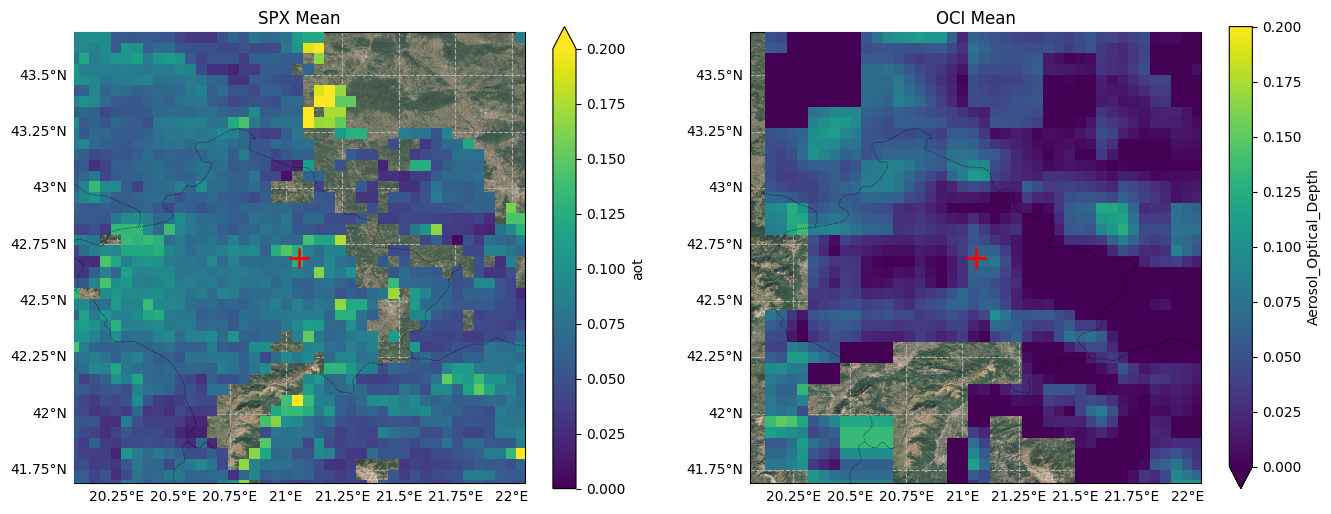

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

cross_lonlat = (21.058555012396997, 42.69174831596751)
cln, clt = cross_lonlat

tiler = cimgt.GoogleTiles(style="satellite")

fig, axes = plt.subplots(
    1, 2,  # 1 row, 2 columns
    figsize=(16, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, da, title in zip(
    axes,
    [da_spx.mean("time"), da_oci_matched.mean("time")],
    ["SPX Mean", "OCI Mean"]
):
    ax.set_extent([region[0], region[2], region[1], region[3]], crs=ccrs.PlateCarree())
    ax.add_image(tiler, 12)

    ax.coastlines(resolution="110m", color="black", linewidth=0.6, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2, zorder=1)

    da.plot.imshow(
        ax=ax,
        transform=ccrs.PlateCarree(),
        robust=True,
        cmap="viridis",
        vmin=0.0, vmax=0.2,   # you might want to standardize for comparison
        zorder=3
    )

    # gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # marker
    ax.plot(
        cln, clt, transform=ccrs.PlateCarree(),
        marker="+", markersize=14, mew=2, mec="red", mfc="none",
        linestyle="none", zorder=4
    )

    ax.set_title(title)

#plt.tight_layout()
plt.show()

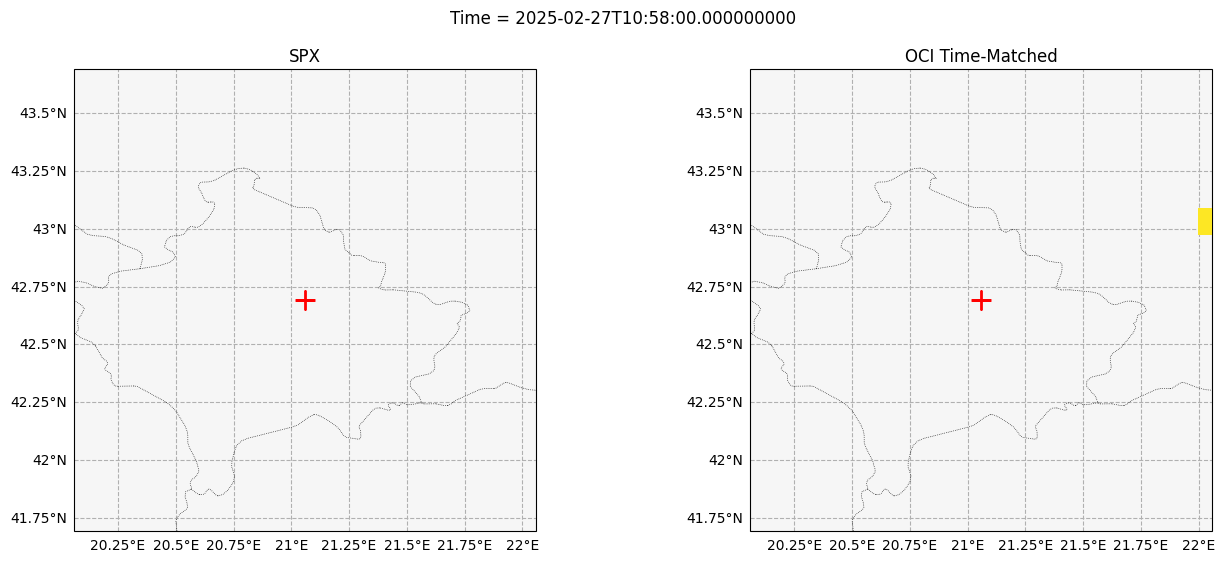

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Cross marker
cross_lonlat = (21.058555012396997, 42.69174831596751)
cln, clt = cross_lonlat

# Create figure with 2 subplots
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Initialize plots for first frame (time=0)
ims = []
for ax, da, title in zip(
    axes,
    [da_spx, da_oci_time_matched],
    ["SPX", "OCI Time-Matched"]
):
    ax.set_extent([region[0], region[2], region[1], region[3]], crs=ccrs.PlateCarree())

    ax.coastlines(resolution="110m", color="black", linewidth=0.6, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2, zorder=1)

    im = da.isel(time=0).plot.imshow(
        ax=ax,
        transform=ccrs.PlateCarree(),
        robust=True,
        cmap="viridis",
        vmin=0.0, vmax=0.2,
        add_colorbar=False,  # avoid duplicate colorbars
        zorder=3
    )
    ims.append(im)

    # gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # marker
    ax.plot(
        cln, clt, transform=ccrs.PlateCarree(),
        marker="+", markersize=14, mew=2, mec="red", mfc="none",
        linestyle="none", zorder=4
    )

    ax.set_title(title)

# Update function for animation
def update(frame):
    ims[0].set_array(da_spx.isel(time=frame).values)
    ims[1].set_array(da_oci_time_matched.isel(time=frame).values)
    fig.suptitle(f"Time = {str(da_spx.time.values[frame])}")
    return ims

# Build animation
ani = animation.FuncAnimation(
    fig, update, frames=len(da_spx.time), interval=600, blit=False
)

# Save animation (choose one)
#ani.save("PACEfun/movies/spx_oci_comparison.mp4", writer="ffmpeg", dpi=150)
ani.save("PACEfun/movies/spx_oci_comparison.gif", writer="pillow", dpi=120)

plt.show()

In [21]:
!pip install imageio imageio-ffmpeg
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import imageio_ffmpeg

# Point Matplotlib to the bundled ffmpeg
plt.rcParams["animation.ffmpeg_path"] = imageio_ffmpeg.get_ffmpeg_exe()

# Create writer
writer = FFMpegWriter(fps=3, metadata=dict(artist="Me"), bitrate=1800)

# Save animation as MP4
ani.save("PACEfun/movies/spx_oci_comparison.mp4", writer=writer, dpi=150)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 97.3 MB/s eta 0:00:00:00:01


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from ipywidgets import interact

def plot_frame(i):
    fig, axes = plt.subplots(
        1, 2, figsize=(16, 6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    for ax, da, title in zip(
        axes,
        [da_spx, da_oci_time_matched],
        ["SPX", "OCI Time-Matched"]
    ):
        ax.set_extent([region[0], region[2], region[1], region[3]], crs=ccrs.PlateCarree())
        ax.coastlines(resolution="110m", color="black", linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2)

        ax.imshow(
            da.isel(time=i).values,
            origin="upper",
            transform=ccrs.PlateCarree(),
            extent=[region[0], region[2], region[1], region[3]],
            cmap="viridis",
            vmin=0.0, vmax=0.2
        )
        # marker
        ax.plot(
            cln, clt, transform=ccrs.PlateCarree(),
            marker="+", markersize=14, mew=2, mec="red", mfc="none",
            linestyle="none", zorder=4
        )
            
        ax.set_title(title)

    fig.suptitle(f"Time = {str(da_spx.time.values[i])}")
    plt.show()

interact(plot_frame, i=widgets.IntSlider(min=0, max=len(da_spx.time)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=32), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_frame(i)>